In [3]:
import numpy as np
from matplotlib import pyplot as plt
import json
import pickle
import os
from tqdm import tqdm
from collections import OrderedDict

results = OrderedDict()
results_base_dir = os.path.join('.', 'results', 'gan_gridsearch_xxiii')
for d in os.listdir(results_base_dir):
    if d.split('_')[0] != 'trial':
        continue
    trial = int(d.split('_')[1])
    repetition = int(d.split('_')[-1])
    if not os.path.exists(os.path.join(results_base_dir, 'trial_{}__rep_{}'.format(trial, repetition), 'sweep_config.json')):
        continue
    with open(os.path.join(results_base_dir, d, 'sweep_config.json'), 'r') as F:
        trial_settings = json.load(F)
    dataset = trial_settings['dataset'].split('.')[-1].split('\'')[0]
    if dataset != 'WatermarkedMNIST':
        continue
    with open(os.path.join(results_base_dir, 'trial_{}__rep_{}'.format(trial, repetition), 'results', 'validation', 'epoch_50.pickle'), 'rb') as F:
        results_ = pickle.load(F)
        orig_leakage = results_['acc_leakage_orig_labels']
        target_leakage = results_['acc_leakage_rec_labels']
        downstream_acc = results_['acc_downstream']
    post_leakage = -np.inf
    for epoch_idx in range(51, 76):
        with open(os.path.join(results_base_dir, 'trial_{}__rep_{}'.format(trial, repetition), 'results', 'validation', 'epoch_{}.pickle'.format(epoch_idx)), 'rb') as F:
            results_ = pickle.load(F)
            if results_['posttrain_leakage_acc'] > post_leakage:
                post_leakage = results_['posttrain_leakage_acc']
    for setting_name, setting_val in trial_settings.items():
        if setting_name == 'dataset':
            continue
        if not setting_name in results.keys():
            results[setting_name] = OrderedDict()
        if not setting_val in results[setting_name].keys():
            results[setting_name][setting_val] = OrderedDict()
        for metric in ['orig_leakage', 'target_leakage', 'downstream_acc', 'post_leakage']:
            if not metric in results[setting_name][setting_val].keys():
                results[setting_name][setting_val][metric] = []
        results[setting_name][setting_val]['orig_leakage'].append(orig_leakage)
        results[setting_name][setting_val]['target_leakage'].append(target_leakage)
        results[setting_name][setting_val]['downstream_acc'].append(downstream_acc)
        results[setting_name][setting_val]['post_leakage'].append(post_leakage)

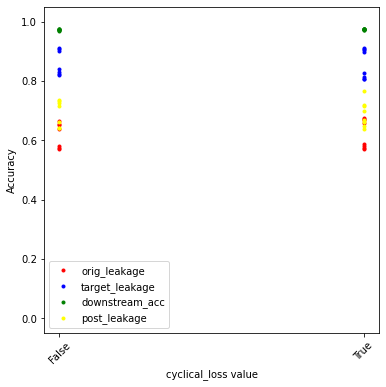

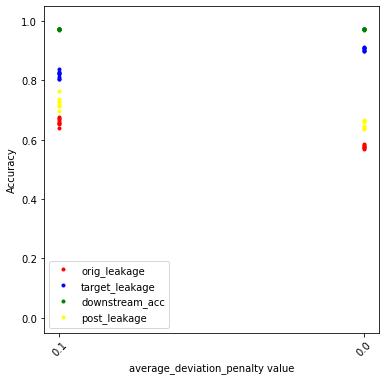

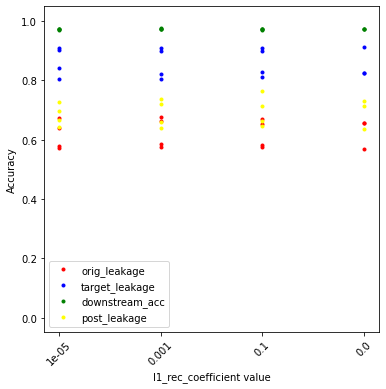

In [5]:
for setting_name in results.keys():
    if len(results[setting_name]) == 1:
        continue
    (fig, ax) = plt.subplots(figsize=(6, 6))
    setting_vals = [x for x in results[setting_name].keys()]
    try:
        setting_vals = [(1.0 if x == 'True' else 0.0) for x in setting_vals]
    except:
        setting_vals = [float(x) for x in setting_vals]
    xticks = np.argsort(setting_vals)
    labels = []
    for xtick, setting_val in zip(xticks, results[setting_name].keys()):
        metrics = results[setting_name][setting_val]
        for (metric_name, metric_vals), color in zip(metrics.items(), ['red', 'blue', 'green', 'yellow']):
            xtick_ = xtick*np.ones(len(metric_vals))
            ax.plot(xtick_, metric_vals, '.', color=color)
            if not metric_name in labels:
                labels.append(metric_name)
    ax.set_xlabel(setting_name + ' value')
    ax.set_ylabel('Accuracy')
    ax.set_ylim(-0.05, 1.05)
    ax.set_xticks(xticks)
    ax.set_xticklabels(list(results[setting_name].keys()), rotation=45)
    ax.legend(labels)